# Decoding a TFRecord file from the ImageNet dataset

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.version.VERSION

'2.7.0'

In [2]:
list_of_files = sorted(glob.glob('/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/*'))
list_of_files[:6], len(list_of_files)

(['/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00000-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00001-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00002-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00003-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00004-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00005-of-00128'],
 128)

In [3]:
sample = next(iter(tf.data.TFRecordDataset(list_of_files[0]).take(1)))
tf.train.Example.FromString(sample.numpy())

2021-11-19 15:44:22.119868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/opt/cray/pe/mpt/7.7.16/gni/mpich-gnu/8.2/lib:/opt/cray/pe/perftools/20.10.0/lib64:/opt/cray/rca/2.2.20-7.0.2.1_2.93__g8e3fb5b.ari/lib64:/opt/cray/pe/pmi/5.0.17/lib64:/opt/cray/pe/libsci/20.09.1/GNU/8.1/x86_64/lib:/apps/daint/UES/jenkins/7.0.UP02-20.11/gpu/easybuild/software/PyTorch/1.9.0-CrayGNU-20.11/lib:/apps/daint/UES/jenkins/7.0.UP02-20.11/gpu/easybuild/software/Boost/1.70.0-CrayGNU-20.11/lib:/apps/daint/UES/jenkins/7.0.UP02-20.11/gpu/easybuild/software/zlib/1.2.11-CrayGNU-20.11/lib:/apps/daint/UES/jenkins/7.0.UP02-20.11/gpu/easybuild/software/bzip2/1.0.6-CrayGNU-20.11/lib:/opt/intel/compilers_and_libraries_2020/linux/mkl/lib/intel64:/apps/daint/UES/jenkins/7.0.UP02-20.11/gpu/easybuild/software/pybind11/2.6.1-CrayGNU-2

features {
  feature {
    key: "image/channels"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "image/class/label"
    value {
      int64_list {
        value: 66
      }
    }
  }
  feature {
    key: "image/class/synset"
    value {
      bytes_list {
        value: "n01751748"
      }
    }
  }
  feature {
    key: "image/colorspace"
    value {
      bytes_list {
        value: "RGB"
      }
    }
  }
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\000`\000`\000\000\377\355\000\034Photoshop 3.0\0008BIM\004\004\000\000\000\000\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\002\002\003\002\002\002\002\002\004\003\003\002\003\005\004\005\005\005\004\004\004\005\006\007\006\005\005\007\006\004\004\006\t\006\007\010\010\010\010\010\005\006\t\n\t\010\n\007\010\010\010\377\333\000C\001\001\001\001\002\002\002\004\002\002\004\010\005\004\0

In [4]:
image_shape = (224, 224)

def decode(serialized_example):
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    image = tf.image.resize_with_crop_or_pad(image, *image_shape)
    label = tf.cast(features['image/class/label'], tf.int64) - 1  # [0-999]
    return image, label

In [5]:
dataset = tf.data.TFRecordDataset(list_of_files)
dataset = dataset.map(decode)
dataset = dataset.batch(3)

Image shape: (3, 224, 224, 3) Labels: [ 65 970 230]


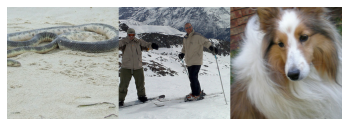

In [6]:
for images, labels in dataset.take(1):
    print('Image shape:', images.shape, 'Labels:', labels.numpy())

concat = np.concatenate(list(images), axis=1)

plt.imshow(concat.astype(int))
plt.axis('off')
plt.show()